<a href="https://colab.research.google.com/github/chm10/VAEM/blob/dev/Main%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAEM: a Deep Generative Model for Heterogeneous Mixed Type Data

VAEM is an extension of variational autoencoders (VAEs) in order to handle such heterogeneous data. It is a deep generative model that is trained in a two stage manner. In the first stage we fit a different VAE independently to each data dimension $x_{nd}$. We call the resulting $D$ models marginal VAEs. Then, in the second stage, in order to capture the inter-variable dependencies, a new multi-dimensional VAE, called the dependency network, is build on top of the latent representations provided by the first-stage encoders. Finally, if the model is used in down stream tasks such as sequential active information acquisition, we often introduce a third stage, which is to add a new discriminator (preditor) model on top of the VAEM outputs. 

Different stages are referred as `1`,`2`, and `3` in `list_stages` in the `.json` files. 

## Usage

To run the demo, you need to first download the [Bank Marketing UCI dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing), 
and put the csv file under `data/bank`. You will need to preprocess the data into the format according to our example .csv 
file (which does not contain any real data). This can done by splitting the text into columns using `;` as delimiters. Then,
simply run `Main_Notebook.ipynb`. This notebook train/or load a VAEM model on Bank dataset, 
and demonstrates how to perform sequential active information acquisition (SAIA) and imputation. 
By default, it trains a new model on Bank dataset. If you would like to load a pre-trained model, by default it will load a pre-trained tensorflow model from `saved_weights/bank/`. Note that in order to perform 
active information acquisition, an additional third stage training is required. This will add a discriminator (predictor)
to the model, which is required for SAIA. The configurations for VAEM can be found in `.json` files in `hyperparameters/bank`, 
which include:
* "list_stage" : list of stages that you would like the model to be trained. stage 1 = training marginal VAEs, stage 2 = training dependency network,  stage 3 = add predictor and improve predictive performance. The default is [1,2]. 
* "epochs" : number of epochs for training VAEM. If you would like to load a pretrained model rather than training a new one, you can simply set this to zero.
* "latent_dim" : size of latent dimensions of dependency network, 
* "p" : upper bound for artificial missingness probability. For example, if set to 0.9, then during each training epoch, the algorithm will randomly choose a probability smaller than 0.9, and randomly drops observations according to this probability. Our suggestion is that if original dataset already contains missing data, you can just set p to 0. 
* "iteration" : iterations (number of mini batches) used per epoch. set to -1 to run the full epoch. If your dataset is large, please set to other values such as 10.
* "batch_size" : iterations (number of mini batches) used per epoch. set to -1 to run the full epoch. If your dataset is large, please set to other values such as 10.
* "K" : the dimension of the feature map (h) dimension of PNP encoder.
* "M" : Number of MC samples when perform imputing. 
* "repeat" : number of repeats.
* "data_name" : name of the dataset being used. Our default is "bank".
* "output_dir" : Directory where the model is stored. Our default is "./saved_weights/bank/",
* "data_dir" : Directory where the data is stored. Our default is "./data/bank/",
* "list_strategy" : list of strategies for active learning, 0 = random, 1 = single ordering. Default: [1]

In [1]:
#! pip install PySUS
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/chm10/VAEM
%cd VAEM

Cloning into 'VAEM'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 41 (delta 8), reused 21 (delta 2), pack-reused 0
Unpacking objects: 100% (41/41), done.
/content/VAEM


## Load modules

In [53]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
from scipy.stats import bernoulli
import os
import random
from random import sample
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import sklearn.preprocessing as preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
plt.switch_backend('agg')
tfd = tf.contrib.distributions
import utils.process as process
import json
import utils.params as params
import seaborn as sns; sns.set(style="ticks", color_codes=True)
%matplotlib inline

1.15.2


## Changing context 

In [4]:
cols = [
    'ID_AGRAVO', 'DT_NOTIFIC', 'SEM_NOT', 'NU_ANO', 'ID_MUNICIP',
    'DT_SIN_PRI', 'SEM_PRI', 'NU_IDADE_N', 'CS_SEXO', 'CS_GESTANT',
    'latitude', 'longitude',
    'NM_DISEASE'
]
casos = pd.read_csv(
    'https://info.dengue.mat.br/dumps/Mosquito.Borne.Disease.tar.gz',
    compression='gzip',
    header=0,
    usecols=cols)

In [5]:
#casos.DT_NOTIFIC = pd.to_datetime(casos.DT_NOTIFIC)
#casos.DT_SIN_PRI = pd.to_datetime(casos.DT_SIN_PRI)
#casos = casos.set_index('DT_NOTIFIC')

In [6]:
casos=casos.loc[0:110286].copy()

In [7]:
casos.head()

,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,ID_MUNICIP,DT_SIN_PRI,SEM_PRI,NU_IDADE_N,CS_SEXO,CS_GESTANT,latitude,longitude,NM_DISEASE
0,A90,2015-09-17,37.0,2015.0,330455.0,2015-08-26,34.0,4039.0,M,6.0,-22.925318,-43.388889,Dengue
1,A90,2015-05-15,19.0,2015.0,330455.0,2015-05-10,19.0,4044.0,F,5.0,-22.872878,-43.425393,Dengue
2,A90,2015-08-14,32.0,2015.0,330455.0,2015-08-08,31.0,4050.0,F,6.0,-22.826738,-43.329702,Dengue
3,A90,2015-08-18,33.0,2015.0,330455.0,2015-06-19,24.0,4056.0,F,9.0,-22.879648,-43.339151,Dengue
4,A90,2015-08-18,33.0,2015.0,330455.0,2015-06-18,24.0,4027.0,F,9.0,-22.814463,-43.380845,Dengue


In [8]:
casos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110287 entries, 0 to 110286
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID_AGRAVO   110287 non-null  object 
 1   DT_NOTIFIC  110287 non-null  object 
 2   SEM_NOT     110287 non-null  float64
 3   NU_ANO      110287 non-null  float64
 4   ID_MUNICIP  110287 non-null  float64
 5   DT_SIN_PRI  110286 non-null  object 
 6   SEM_PRI     110286 non-null  float64
 7   NU_IDADE_N  110287 non-null  float64
 8   CS_SEXO     110283 non-null  object 
 9   CS_GESTANT  110267 non-null  float64
 10  latitude    110156 non-null  float64
 11  longitude   110156 non-null  float64
 12  NM_DISEASE  110287 non-null  object 
dtypes: float64(8), object(5)
memory usage: 10.9+ MB


In [41]:
casosnona=casos.dropna().reset_index(drop=True)

In [42]:
casos[["ID_AGRAVO","CS_SEXO", "DT_NOTIFIC", "DT_SIN_PRI", "NM_DISEASE"]] = casos[["ID_AGRAVO","CS_SEXO", "DT_NOTIFIC", "DT_SIN_PRI", "NM_DISEASE"]].values.astype(str)


## load hyperparameters

In [43]:
args = params.Params('./hyperparameters/bank_plot.json')

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)  
rs = 42 # random seed
fast_plot = 0

## Load Bank Data

In [44]:
seed = 3000
dengue_raw = casosnona
print(dengue_raw.info())
label_column="NM_DISEASE"
matrix1 = dengue_raw.copy()


process.encode_catrtogrial_column(matrix1, ["ID_AGRAVO"])
process.encode_catrtogrial_column(matrix1, ["CS_SEXO"])
process.encode_catrtogrial_column(matrix1, ["DT_NOTIFIC"])
process.encode_catrtogrial_column(matrix1, ["DT_SIN_PRI"])
process.encode_catrtogrial_column(matrix1, ["NM_DISEASE"])

Data = ((matrix1.values).astype(float))[0:,:]





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110136 entries, 0 to 110135
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID_AGRAVO   110136 non-null  object 
 1   DT_NOTIFIC  110136 non-null  object 
 2   SEM_NOT     110136 non-null  float64
 3   NU_ANO      110136 non-null  float64
 4   ID_MUNICIP  110136 non-null  float64
 5   DT_SIN_PRI  110136 non-null  object 
 6   SEM_PRI     110136 non-null  float64
 7   NU_IDADE_N  110136 non-null  float64
 8   CS_SEXO     110136 non-null  object 
 9   CS_GESTANT  110136 non-null  float64
 10  latitude    110136 non-null  float64
 11  longitude   110136 non-null  float64
 12  NM_DISEASE  110136 non-null  object 
dtypes: float64(8), object(5)
memory usage: 10.9+ MB
None


In [46]:
casosnona[casosnona.iloc[:,10].isna()]

,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,ID_MUNICIP,DT_SIN_PRI,SEM_PRI,NU_IDADE_N,CS_SEXO,CS_GESTANT,latitude,longitude,NM_DISEASE


## Specify parameters for data preprocessing

In [47]:
# the data will be mapped to interval [min_Data,max_Data]. Usually this will be [0,1] but you can also specify other values.
max_Data = 0.7 
min_Data = 0.3 
# list of categorical variables
list_cat = np.array([0,12])
# list of numerical variables
list_flt = np.array([10,11])
# among numerical variables, which ones are discrete. This is referred as continuous-discrete variables in Appendix C.1.3 in our paper.
# Examples include variables that take integer values, for example month, day of week, number of custumors etc. Other examples include numerical variables that are recorded on a discrete grid (for example salary). 
list_discrete = np.array([2,3,4,6,7,9])

## Data pre-processing (decompressing)

Here we basically do two things. First, the raw data matrix is sorted and normalized (squashed). Then, we will "decompress" the categorical variables in the raw data matrix into one-hot encoding features. In our implementations, we always use the suffix `_decomressed` to indicate any variables that are based on one-hot representations for categorical variables. For example, `Mask_decompressed` is the missingness indicator of the data matrix after decompressed into one-hot encodings.

In [48]:
# sort the variables in the data matrix, so that categorical variables appears first. The resulting data matrix is Data_sub
list_discrete_in_flt = (np.in1d(list_flt, list_discrete).nonzero()[0])
list_discrete_compressed = list_discrete_in_flt + len(list_cat)

if len(list_flt)>0 and len(list_cat)>0:
    list_var = np.concatenate((list_cat,list_flt))
elif len(list_flt)>0:
    list_var = list_flt
else:
    list_var = list_cat
Data_sub = Data[:,list_var]
dic_var_type = np.zeros(Data_sub.shape[1])
dic_var_type[0:len(list_cat)] = 1

# In this notebook we assume the raw data matrix is fully observed
Mask = np.ones(Data_sub.shape)
# Normalize/squash the data matrix
Data_std = (Data_sub - Data_sub.min(axis=0)) / (Data_sub.max(axis=0) - Data_sub.min(axis=0))
scaling_factor = (Data_sub.max(axis=0) - Data_sub.min(axis=0))/(max_Data - min_Data)
Data_sub = Data_std * (max_Data - min_Data) + min_Data

# decompress categorical data into one hot representation
Data_cat = Data[:,list_cat].copy()
Data_flt = Data[:,list_flt].copy()
Data_compressed = np.concatenate((Data_cat,Data_flt),axis = 1)
Data_decompressed, Mask_decompressed, cat_dims, DIM_FLT = process.data_preprocess(Data_sub,Mask,dic_var_type)
Data_train_decompressed, Data_test_decompressed, mask_train_decompressed, mask_test_decompressed,mask_train_compressed, mask_test_compressed,Data_train_compressed, Data_test_compressed = train_test_split(
        Data_decompressed, Mask_decompressed,Mask,Data_compressed,test_size=0.1, random_state=rs)

list_discrete = list_discrete_in_flt + (cat_dims.sum()).astype(int)

Data_decompressed = np.concatenate((Data_train_decompressed, Data_test_decompressed), axis=0)
Data_train_orig = Data_train_decompressed.copy()
Data_test_orig = Data_test_decompressed.copy()

# Note that here we have added some noise to continuous-discrete variables to help training. Alternatively, you can also disable this by changing the noise ratio to 0.
Data_noisy_decompressed,records_d, intervals_d = process.noisy_transform(Data_decompressed, list_discrete, noise_ratio = 0.99)
noise_record = Data_noisy_decompressed - Data_decompressed
Data_train_noisy_decompressed = Data_noisy_decompressed[0:Data_train_decompressed.shape[0],:]
Data_test_noisy_decompressed = Data_noisy_decompressed[Data_train_decompressed.shape[0]:,:]




In [49]:
list_discrete_compressed

array([], dtype=int64)

## Load or Train a VAEM model

In [50]:
import utils.active_learning as active_learning
vae = active_learning.p_vae_active_learning(Data_train_compressed, Data_train_noisy_decompressed,mask_train_decompressed,Data_test_decompressed,mask_test_compressed,mask_test_decompressed,cat_dims,DIM_FLT,dic_var_type,args)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch: 1179 	negative training ELBO per observed feature: -1.43, Cat_term: 0.16, Flt_term: -1.66,z_term: 0.00
Epoch: 1180 	negative training ELBO per observed feature: -1.40, Cat_term: 0.15, Flt_term: -1.62,z_term: 0.00
Epoch: 1181 	negative training ELBO per observed feature: -1.38, Cat_term: 0.15, Flt_term: -1.60,z_term: 0.00
Epoch: 1182 	negative training ELBO per observed feature: -1.43, Cat_term: 0.15, Flt_term: -1.65,z_term: 0.00
Epoch: 1183 	negative training ELBO per observed feature: -1.37, Cat_term: 0.16, Flt_term: -1.60,z_term: 0.00
Epoch: 1184 	negative training ELBO per observed feature: -1.41, Cat_term: 0.15, Flt_term: -1.62,z_term: 0.00
Epoch: 1185 	negative training ELBO per observed feature: -1.38, Cat_term: 0.15, Flt_term: -1.60,z_term: 0.00
Epoch: 1186 	negative training ELBO per observed feature: -1.36, Cat_term: 0.15, Flt_term: -1.58,z_term: 0.00
Epoch: 1187 	negative training ELBO per observed feature: -1.

## Use the model to impute data and generate pairplots

2.0
2.0
2.0
2.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

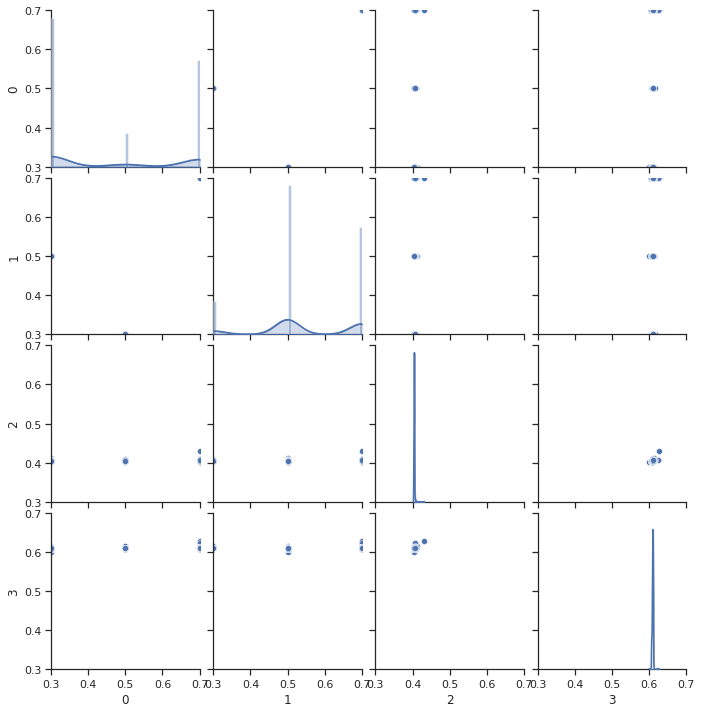

In [56]:

tf.reset_default_graph()
### Impute missing data. Fthe mask to be zeros

x_recon,z_posterior,x_recon_cat_p = vae.get_imputation( Data_train_noisy_decompressed, mask_train_decompressed*0,cat_dims,dic_var_type) ## one hot already cpverted to integer


x_real = process.compress_data(Data_train_decompressed,cat_dims, dic_var_type) ## x_real still needs conversion
x_real_cat_p = Data_train_decompressed[:,0:(cat_dims.sum()).astype(int)]


# max_Data = 0.7
# min_Data = 0.3  
Data_std = (x_real - x_real.min(axis=0)) / (x_real.max(axis=0) - x_real.min(axis=0))
scaling_factor = (x_real.max(axis=0) - x_real.min(axis=0))/(max_Data - min_Data)
Data_real = Data_std * (max_Data - min_Data) + min_Data

fast_plot = 1

sub_id = [0,1,2,3]
if fast_plot ==1:
    Data_real = pd.DataFrame(Data_real[:,sub_id])
    g = sns.pairplot(Data_real.sample(min(1000,x_real.shape[0])),diag_kind = 'kde')
    g = g.map_diag(sns.distplot, bins = 50,norm_hist = True)
    g.set(xlim=(min_Data,max_Data), ylim = (min_Data,max_Data))
else:
    Data_real = pd.DataFrame(Data_real[:,sub_id])
    g = sns.pairplot(Data_real.sample(min(10000,x_real.shape[0])),diag_kind = 'kde')
    g = g.map_diag(sns.distplot, bins = 50,norm_hist = True)
    g = g.map_upper(plt.scatter,marker='+')
    g = g.map_lower(sns.kdeplot, cmap="hot",shade=True,bw=.1)
    g.set(xlim=(min_Data,max_Data), ylim = (min_Data,max_Data))




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

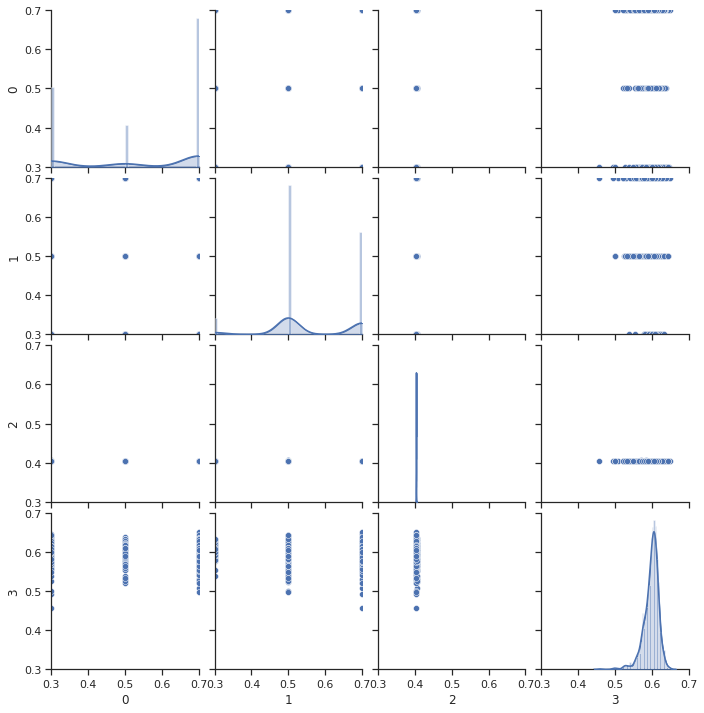

In [57]:
Data_fake_noisy= x_recon
Data_fake = process.invert_noise(Data_fake_noisy,list_discrete_compressed,records_d) 

Data_std = (Data_fake - x_real.min(axis=0)) / (x_real.max(axis=0) - x_real.min(axis=0))
Data_fake = Data_std * (max_Data - min_Data) + min_Data


sub_id = [0,1,2,3]

if fast_plot ==1:
    g = sns.pairplot(pd.DataFrame(Data_fake[:,sub_id]).sample(min(1000,x_real.shape[0])),diag_kind = 'kde')
    g = g.map_diag(sns.distplot, bins = 50,norm_hist = True)
    g.set(xlim=(min_Data,max_Data), ylim = (min_Data,max_Data))
else:
    g = sns.pairplot(pd.DataFrame(Data_fake[:,sub_id]).sample(min(1000,x_real.shape[0])),diag_kind = 'kde')
    g = g.map_diag(sns.distplot, bins = 50,norm_hist = True)
    g = g.map_upper(plt.scatter,marker='+')
    g = g.map_lower(sns.kdeplot, cmap="hot",shade=True,bw=.1)
    g.set(xlim=(min_Data,max_Data), ylim = (min_Data,max_Data))

    


## Train a discriminator on top of the model and perform SAIA

In [58]:
args = params.Params('./hyperparameters/bank_SAIA.json')
import utils.active_learning as active_learning
vae = active_learning.p_vae_active_learning(Data_train_compressed, Data_train_noisy_decompressed,mask_train_decompressed,Data_test_decompressed,mask_test_compressed,mask_test_decompressed,cat_dims,DIM_FLT,dic_var_type,args)

Tensor("is/generator/mul_5:0", shape=(?, 7), dtype=float32)
Tensor("is/generator/mul_13:0", shape=(?, 7), dtype=float32)


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from ./saved_weights/bank/encoder.tensorflow
INFO:tensorflow:Restoring parameters from ./saved_weights/bank/generator.tensorflow
Epoch: 0 	negative training ELBO per observed feature: -0.03, Cat_term: 0.13, Flt_term: -1.78,z_term: -1.17
Epoch: 1 	negative training ELBO per observed feature: -0.10, Cat_term: 0.13, Flt_term: -1.76,z_term: -1.14
Epoch: 2 	negative training ELBO per observed feature: -0.18, Cat_term: 0.12, Flt_term: -1.77,z_term: -1.14
Epoch: 3 	negative training ELBO per observed feature: -0.08, Cat_term: 0.12, Flt_term: -1.77,z_term: -1.14
Epoch: 4 	negative training ELBO per observed feature: -0.19, Cat_term: 0.12, Flt_term: -1.75,z_term: -1.13
Epoch: 5 	negative training ELBO per observed feature: -0.15, Cat_term: 0.12, Flt_term: -1.80,z_term: -1.16
Epoch: 6 	negative training ELBO per observed feature: -0.17, Cat_term: 0.13, Flt_term: -1.78,z_term: -1.15
Epoch: 7 	negative training ELBO per observed feature: -0.10, Cat_term: 0.12, 

## Visualization of SAIA results

<Figure size 432x288 with 0 Axes>

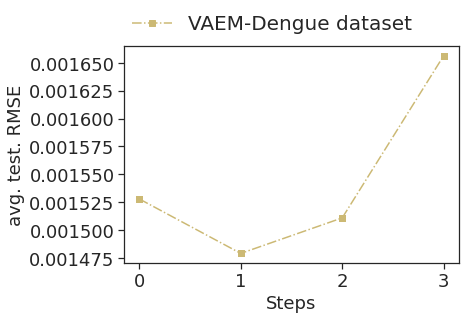

In [59]:
npzfile = np.load(args.output_dir+'/UCI_rmse_curve_SING.npz')
IC_SING=npzfile['information_curve']*scaling_factor[-1]

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.figure(0)
L = IC_SING.shape[1]
fig, ax1 = plt.subplots()
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.45, 0.4, 0.45, 0.45]
ax1.plot(np.sqrt((IC_SING[:,:,0:]**2).mean(axis=1)).mean(axis=0),'ys',linestyle = '-.', label = 'VAEM-Dengue dataset')
ax1.errorbar(np.arange(IC_SING.shape[2]),np.sqrt((IC_SING[:,:,0:]**2).mean(axis=1)).mean(axis=0), yerr=np.sqrt((IC_SING[:,:,0:]**2).mean(axis=1)).std(axis = 0)/np.sqrt(IC_SING.shape[0]),ecolor='y',fmt = 'ys')
plt.xlabel('Steps',fontsize=18)
plt.ylabel('avg. test. RMSE',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.legend(bbox_to_anchor=(0.0, 1.02, 1., .102), mode = "expand", loc=3,
           ncol=1, borderaxespad=0.,prop={'size': 20}, frameon=False)
ax1.ticklabel_format(useOffset=False)
plt.show()
